In [1]:
pip install cartopy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


Calculating PV output for varying grid resolutions:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_3584\66306380.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\66306380.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\66306380.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\

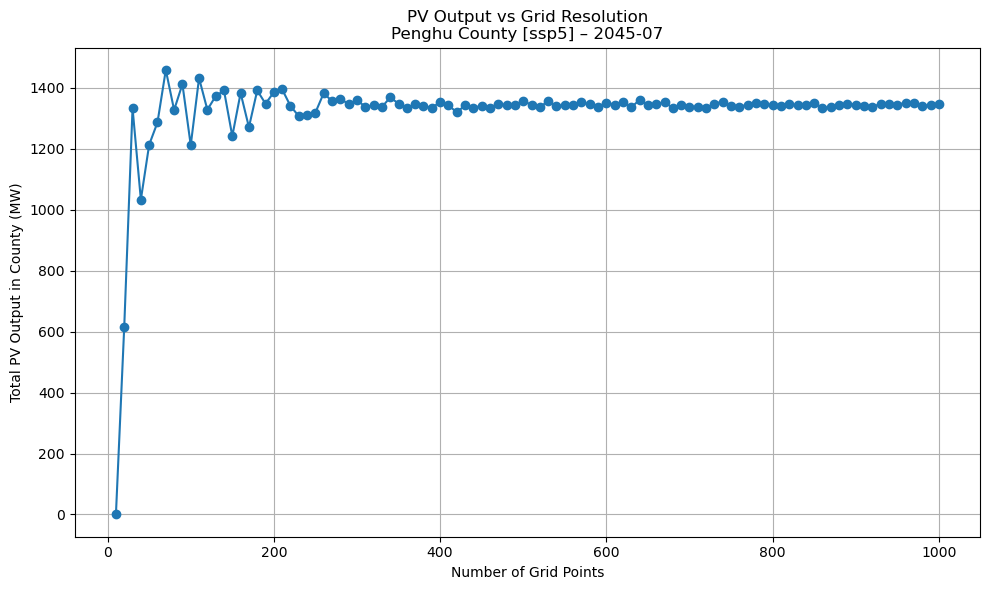

Processing complete. Final PV output at highest resolution: 1346.67 MW


In [4]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from tqdm import tqdm
from shapely.vectorized import contains
from scipy.spatial.distance import cdist

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp5'
target_month = '2045-07'
target_county = '澎湖縣'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]
if county_row.empty:
    raise ValueError("Target county not found.")
county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 3. Set constants for PV calculation
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
geod = Geod(ellps="WGS84")

# --------------------------------------
# 4. Optimized helper functions
# --------------------------------------
def calculate_cell_areas_vectorized(lon2d, lat2d):
    """Vectorized calculation of cell areas using approximate formula"""
    # Convert to radians
    lon_rad = np.radians(lon2d)
    lat_rad = np.radians(lat2d)
    
    # Earth radius in meters
    R = 6371000
    
    # Calculate differences (approximate grid spacing)
    if lon2d.shape[0] > 1 and lon2d.shape[1] > 1:
        dlat = np.abs(lat_rad[1,0] - lat_rad[0,0])
        dlon = np.abs(lon_rad[0,1] - lon_rad[0,0])
        
        # Approximate area calculation using spherical approximation
        # Area = R² * dlon * dlat * cos(lat)
        cos_lat = np.cos(lat_rad)
        cell_areas = R**2 * dlon * dlat * cos_lat
    else:
        cell_areas = np.zeros_like(lon2d)
    
    return cell_areas

def get_county_mask_vectorized(lon2d, lat2d, county_geom):
    """Vectorized point-in-polygon check"""
    # Flatten coordinates for vectorized operations
    lon_flat = lon2d.flatten()
    lat_flat = lat2d.flatten()
    
    # Use shapely's vectorized contains function
    mask_flat = contains(county_geom, lon_flat, lat_flat)
    
    # Reshape back to grid
    return mask_flat.reshape(lon2d.shape)

def smart_interpolation(df_month, lon2d, lat2d, max_distance=0.5):
    """Optimized interpolation with distance-based filtering"""
    points = df_month[["lon", "lat"]].values
    values = df_month["rsds"].values
    
    # Create grid points
    grid_points = np.column_stack([lon2d.flatten(), lat2d.flatten()])
    
    # Calculate distances to find nearest neighbors efficiently
    distances = cdist(grid_points, points)
    
    # Only interpolate for points that have nearby data
    min_distances = distances.min(axis=1)
    valid_mask = min_distances <= max_distance
    
    # Initialize result array
    result = np.full(len(grid_points), np.nan)
    
    if np.any(valid_mask):
        # Interpolate only for valid points
        valid_grid_points = grid_points[valid_mask]
        try:
            valid_interpolated = griddata(points, values, valid_grid_points, method='cubic')
            result[valid_mask] = valid_interpolated
        except:
            # Fallback to linear if cubic fails
            valid_interpolated = griddata(points, values, valid_grid_points, method='linear')
            result[valid_mask] = valid_interpolated
    
    return result.reshape(lon2d.shape)

# --------------------------------------
# 5. Optimized main loop
# --------------------------------------
num_points_list = list(range(10, 1001, 10))
pvout_list = []

# Pre-filter the region to focus on area around the county
county_bounds = county_geom.bounds
lon_min, lat_min, lon_max, lat_max = county_bounds
# Add buffer for interpolation
buffer = 0.5
lon_range = [max(119, lon_min - buffer), min(123, lon_max + buffer)]
lat_range = [max(21, lat_min - buffer), min(26, lat_max + buffer)]

for num_points in tqdm(num_points_list, desc="Calculating PV output for varying grid resolutions"):
    # Create focused grid around the county
    lon_grid = np.linspace(lon_range[0], lon_range[1], num_points)
    lat_grid = np.linspace(lat_range[0], lat_range[1], num_points)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
    
    # Fast interpolation with distance filtering
    grid_rsds = smart_interpolation(df_month, lon2d, lat2d)
    masked_rsds = ma.masked_invalid(grid_rsds)
    
    # Fast area calculation
    cell_areas = calculate_cell_areas_vectorized(lon2d, lat2d)
    
    # Vectorized county mask
    county_mask = get_county_mask_vectorized(lon2d, lat2d, county_geom)
    
    # Vectorized calculation of total PV output
    # Only calculate for valid rsds values within county
    valid_mask = ~masked_rsds.mask & county_mask
    
    if np.any(valid_mask):
        valid_rsds = masked_rsds[valid_mask]
        valid_areas = cell_areas[valid_mask]
        
        # Vectorized calculation
        potential_array = valid_rsds * valid_areas * efficiency * panel_ratio
        total_potential = np.sum(potential_array)
    else:
        total_potential = 0
    
    total_potential_MW = total_potential / 1e6  # convert to MW
    pvout_list.append(total_potential_MW)

# --------------------------------------
# 6. Plot: num_points vs total PV output
# --------------------------------------
plt.figure(figsize=(10,6))
plt.plot(num_points_list, pvout_list, marker='o')
plt.xlabel("Number of Grid Points")
plt.ylabel("Total PV Output in County (MW)")
plt.title(f"PV Output vs Grid Resolution\n{target_county_eng} [{ssp_target}] – {target_month}")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Processing complete. Final PV output at highest resolution: {pvout_list[-1]:.2f} MW")

Calculating PV output for varying grid resolutions:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_3584\1875026440.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\1875026440.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\1875026440.py:92: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_fla

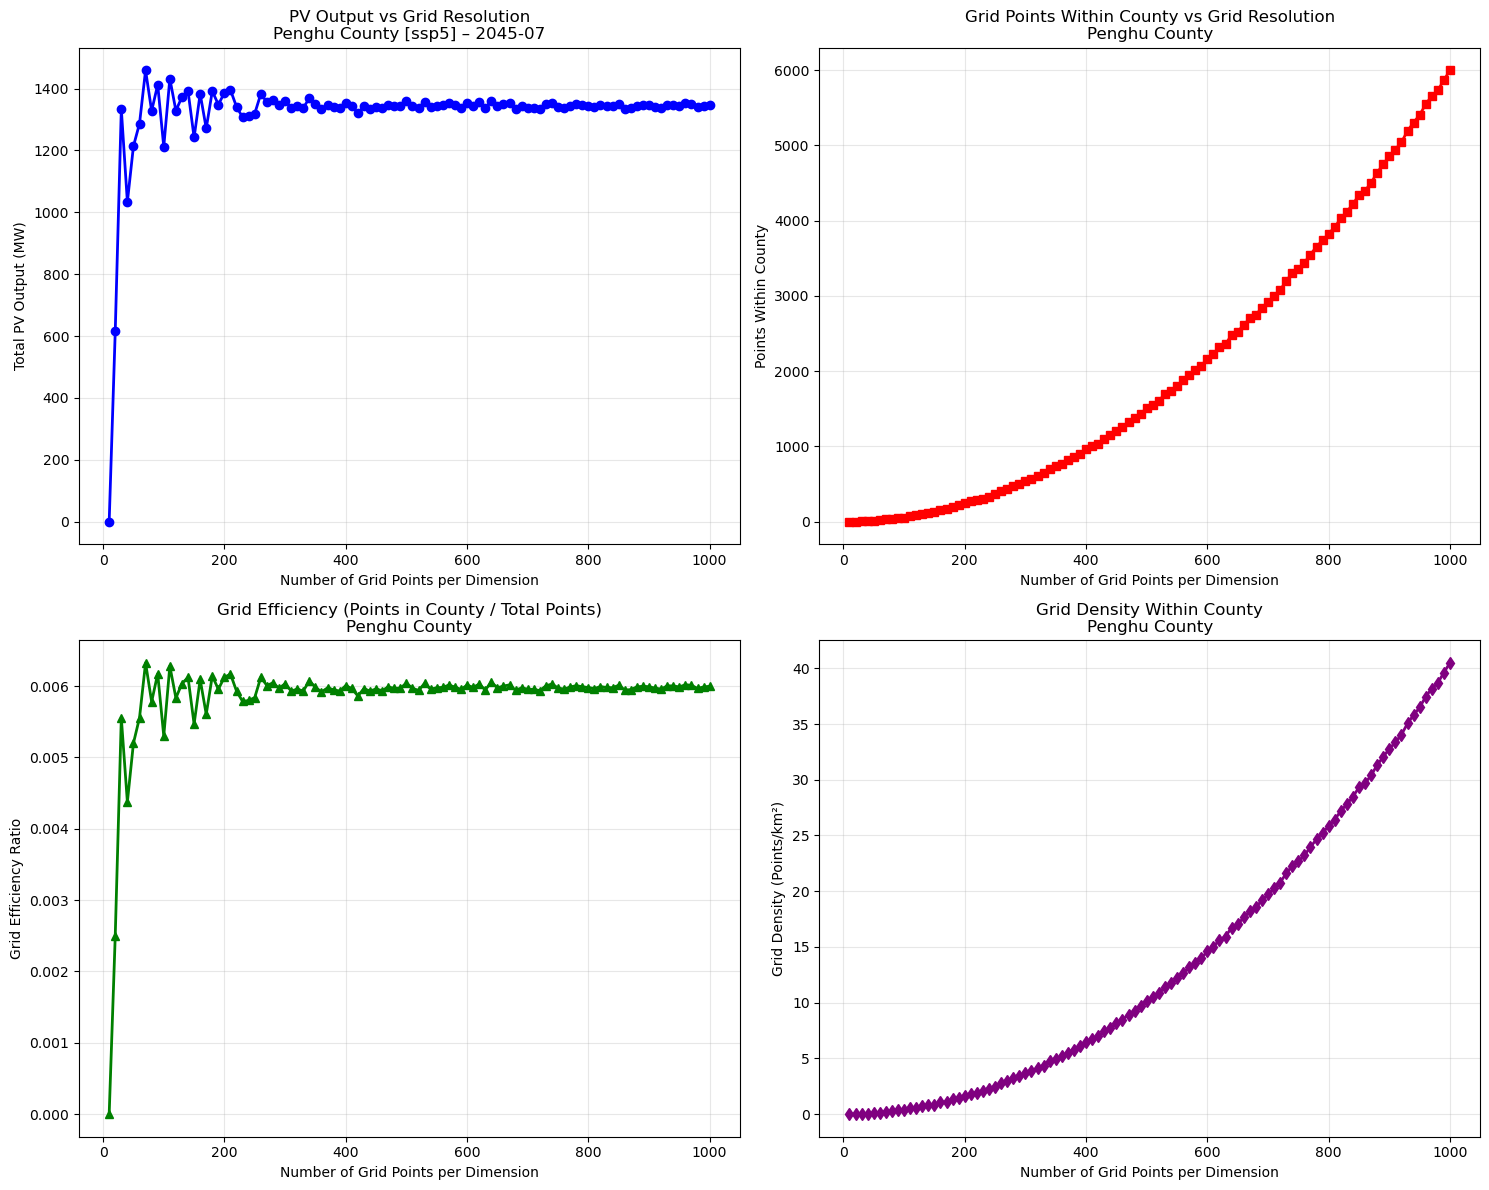


GRID ANALYSIS SUMMARY
Target County: 澎湖縣 (Penghu County)
County Area: 148.13 km²
SSP Scenario: ssp5
Target Month: 2045-07

------------------------------------------------------------
GRID RESOLUTION ANALYSIS
------------------------------------------------------------
Suggested optimal grid resolution: 1000 points per dimension
At optimal resolution:
  - Points within county: 5998
  - Grid density: 40.49 points/km²
  - PV output: 1346.67 MW

At maximum resolution (1000 points):
  - Points within county: 5998
  - Grid density: 40.49 points/km²
  - PV output: 1346.67 MW
  - Grid efficiency: 0.6%

Processing complete!

Results DataFrame shape: (100, 6)

First few rows:
   grid_resolution  total_grid_points  points_in_county  \
0               10                100                 0   
1               20                400                 1   
2               30                900                 5   
3               40               1600                 7   
4               50          

In [7]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from tqdm import tqdm
from shapely.vectorized import contains
from scipy.spatial.distance import cdist

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp5'
target_month = '2045-07'
target_county = '澎湖縣'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]
if county_row.empty:
    raise ValueError("Target county not found.")
county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 3. Set constants for PV calculation
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
geod = Geod(ellps="WGS84")

# --------------------------------------
# 4. Optimized helper functions
# --------------------------------------
def calculate_cell_areas_vectorized(lon2d, lat2d):
    """Vectorized calculation of cell areas using approximate formula"""
    # Convert to radians
    lon_rad = np.radians(lon2d)
    lat_rad = np.radians(lat2d)
    
    # Earth radius in meters
    R = 6371000
    
    # Calculate differences (approximate grid spacing)
    if lon2d.shape[0] > 1 and lon2d.shape[1] > 1:
        dlat = np.abs(lat_rad[1,0] - lat_rad[0,0])
        dlon = np.abs(lon_rad[0,1] - lon_rad[0,0])
        
        # Approximate area calculation using spherical approximation
        # Area = R² * dlon * dlat * cos(lat)
        cos_lat = np.cos(lat_rad)
        cell_areas = R**2 * dlon * dlat * cos_lat
    else:
        cell_areas = np.zeros_like(lon2d)
    
    return cell_areas

def get_county_mask_vectorized(lon2d, lat2d, county_geom):
    """Vectorized point-in-polygon check"""
    # Flatten coordinates for vectorized operations
    lon_flat = lon2d.flatten()
    lat_flat = lat2d.flatten()
    
    # Use shapely's vectorized contains function
    mask_flat = contains(county_geom, lon_flat, lat_flat)
    
    # Reshape back to grid
    return mask_flat.reshape(lon2d.shape)

def count_points_in_county(lon2d, lat2d, county_geom):
    """Count how many grid points fall within the county boundary"""
    county_mask = get_county_mask_vectorized(lon2d, lat2d, county_geom)
    return np.sum(county_mask)

def smart_interpolation(df_month, lon2d, lat2d, max_distance=0.5):
    """Optimized interpolation with distance-based filtering"""
    points = df_month[["lon", "lat"]].values
    values = df_month["rsds"].values
    
    # Create grid points
    grid_points = np.column_stack([lon2d.flatten(), lat2d.flatten()])
    
    # Calculate distances to find nearest neighbors efficiently
    distances = cdist(grid_points, points)
    
    # Only interpolate for points that have nearby data
    min_distances = distances.min(axis=1)
    valid_mask = min_distances <= max_distance
    
    # Initialize result array
    result = np.full(len(grid_points), np.nan)
    
    if np.any(valid_mask):
        # Interpolate only for valid points
        valid_grid_points = grid_points[valid_mask]
        try:
            valid_interpolated = griddata(points, values, valid_grid_points, method='cubic')
            result[valid_mask] = valid_interpolated
        except:
            # Fallback to linear if cubic fails
            valid_interpolated = griddata(points, values, valid_grid_points, method='linear')
            result[valid_mask] = valid_interpolated
    
    return result.reshape(lon2d.shape)

# --------------------------------------
# 5. Enhanced main loop with point tracking
# --------------------------------------
num_points_list = list(range(10, 1001, 10))
pvout_list = []
points_in_county_list = []  # NEW: Track points within county
total_grid_points_list = []  # NEW: Track total grid points
grid_density_list = []  # NEW: Track grid density (points per km²)

# Pre-filter the region to focus on area around the county
county_bounds = county_geom.bounds
lon_min, lat_min, lon_max, lat_max = county_bounds
# Add buffer for interpolation
buffer = 0.5
lon_range = [max(119, lon_min - buffer), min(123, lon_max + buffer)]
lat_range = [max(21, lat_min - buffer), min(26, lat_max + buffer)]

# Calculate county area for density calculation
county_area_km2 = county_geom.area * 111.32**2  # Approximate conversion to km²

for num_points in tqdm(num_points_list, desc="Calculating PV output for varying grid resolutions"):
    # Create focused grid around the county
    lon_grid = np.linspace(lon_range[0], lon_range[1], num_points)
    lat_grid = np.linspace(lat_range[0], lat_range[1], num_points)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
    
    # NEW: Count points within county and calculate grid statistics
    points_in_county = count_points_in_county(lon2d, lat2d, county_geom)
    total_grid_points = num_points * num_points
    grid_density = points_in_county / county_area_km2 if county_area_km2 > 0 else 0
    
    # Store the tracking information
    points_in_county_list.append(points_in_county)
    total_grid_points_list.append(total_grid_points)
    grid_density_list.append(grid_density)
    
    # Fast interpolation with distance filtering
    grid_rsds = smart_interpolation(df_month, lon2d, lat2d)
    masked_rsds = ma.masked_invalid(grid_rsds)
    
    # Fast area calculation
    cell_areas = calculate_cell_areas_vectorized(lon2d, lat2d)
    
    # Vectorized county mask
    county_mask = get_county_mask_vectorized(lon2d, lat2d, county_geom)
    
    # Vectorized calculation of total PV output
    # Only calculate for valid rsds values within county
    valid_mask = ~masked_rsds.mask & county_mask
    
    if np.any(valid_mask):
        valid_rsds = masked_rsds[valid_mask]
        valid_areas = cell_areas[valid_mask]
        
        # Vectorized calculation
        potential_array = valid_rsds * valid_areas * efficiency * panel_ratio
        total_potential = np.sum(potential_array)
    else:
        total_potential = 0
    
    total_potential_MW = total_potential / 1e6  # convert to MW
    pvout_list.append(total_potential_MW)

# --------------------------------------
# 6. Enhanced plotting with multiple subplots
# --------------------------------------
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: PV Output vs Grid Resolution
ax1.plot(num_points_list, pvout_list, marker='o', color='blue', linewidth=2)
ax1.set_xlabel("Number of Grid Points per Dimension")
ax1.set_ylabel("Total PV Output (MW)")
ax1.set_title(f"PV Output vs Grid Resolution\n{target_county_eng} [{ssp_target}] – {target_month}")
ax1.grid(True, alpha=0.3)

# Plot 2: Points within County vs Grid Resolution
ax2.plot(num_points_list, points_in_county_list, marker='s', color='red', linewidth=2)
ax2.set_xlabel("Number of Grid Points per Dimension")
ax2.set_ylabel("Points Within County")
ax2.set_title(f"Grid Points Within County vs Grid Resolution\n{target_county_eng}")
ax2.grid(True, alpha=0.3)

# Plot 3: Grid Efficiency (Points in County / Total Grid Points)
efficiency_ratio = [p_in/p_total for p_in, p_total in zip(points_in_county_list, total_grid_points_list)]
ax3.plot(num_points_list, efficiency_ratio, marker='^', color='green', linewidth=2)
ax3.set_xlabel("Number of Grid Points per Dimension")
ax3.set_ylabel("Grid Efficiency Ratio")
ax3.set_title(f"Grid Efficiency (Points in County / Total Points)\n{target_county_eng}")
ax3.grid(True, alpha=0.3)

# Plot 4: Grid Density (Points per km²)
ax4.plot(num_points_list, grid_density_list, marker='d', color='purple', linewidth=2)
ax4.set_xlabel("Number of Grid Points per Dimension")
ax4.set_ylabel("Grid Density (Points/km²)")
ax4.set_title(f"Grid Density Within County\n{target_county_eng}")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------
# 7. Summary statistics and analysis
# --------------------------------------
print("\n" + "="*60)
print("GRID ANALYSIS SUMMARY")
print("="*60)
print(f"Target County: {target_county} ({target_county_eng})")
print(f"County Area: {county_area_km2:.2f} km²")
print(f"SSP Scenario: {ssp_target}")
print(f"Target Month: {target_month}")
print("\n" + "-"*60)
print("GRID RESOLUTION ANALYSIS")
print("-"*60)

# Find optimal grid resolution (where PV output starts to converge)
pv_changes = [abs(pvout_list[i+1] - pvout_list[i]) for i in range(len(pvout_list)-1)]
convergence_threshold = 0.01  # 1% change threshold
for i, change in enumerate(pv_changes):
    if change < convergence_threshold:
        optimal_resolution = num_points_list[i]
        break
else:
    optimal_resolution = num_points_list[-1]

print(f"Suggested optimal grid resolution: {optimal_resolution} points per dimension")
print(f"At optimal resolution:")
print(f"  - Points within county: {points_in_county_list[num_points_list.index(optimal_resolution)]}")
print(f"  - Grid density: {grid_density_list[num_points_list.index(optimal_resolution)]:.2f} points/km²")
print(f"  - PV output: {pvout_list[num_points_list.index(optimal_resolution)]:.2f} MW")

print(f"\nAt maximum resolution ({num_points_list[-1]} points):")
print(f"  - Points within county: {points_in_county_list[-1]}")
print(f"  - Grid density: {grid_density_list[-1]:.2f} points/km²")
print(f"  - PV output: {pvout_list[-1]:.2f} MW")
print(f"  - Grid efficiency: {efficiency_ratio[-1]:.1%}")

print(f"\nProcessing complete!")

# --------------------------------------
# 8. Optional: Export results to CSV
# --------------------------------------
results_df = pd.DataFrame({
    'grid_resolution': num_points_list,
    'total_grid_points': total_grid_points_list,
    'points_in_county': points_in_county_list,
    'grid_efficiency_ratio': efficiency_ratio,
    'grid_density_per_km2': grid_density_list,
    'pv_output_MW': pvout_list
})

# Uncomment the line below to save results
# results_df.to_csv(f'grid_analysis_{target_county_eng}_{ssp_target}_{target_month}.csv', index=False)
print(f"\nResults DataFrame shape: {results_df.shape}")
print("\nFirst few rows:")
print(results_df.head())

=== PERFORMANCE COMPARISON ===

--- Grid size: 30 x 30 ---

1. Interpolation comparison:
original_interpolation took 0.005 seconds
optimized_interpolation took 0.006 seconds

2. Area calculation comparison:
calculate_cell_areas_original took 0.006 seconds
calculate_cell_areas_vectorized took 0.000 seconds

3. PV potential calculation comparison:
calculate_pv_potential_original took 0.028 seconds
calculate_pv_potential_optimized took 0.003 seconds
PV potential (original): 14478.74 MW
PV potential (optimized): 14521.68 MW
Difference: 42.94 MW (0.3%)

--- Grid size: 50 x 50 ---

1. Interpolation comparison:
original_interpolation took 0.006 seconds
optimized_interpolation took 0.009 seconds

2. Area calculation comparison:
calculate_cell_areas_original took 0.016 seconds
calculate_cell_areas_vectorized took 0.000 seconds

3. PV potential calculation comparison:
calculate_pv_potential_original took 0.059 seconds
calculate_pv_potential_optimized took 0.001 seconds
PV potential (original): 1

C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)


calculate_cell_areas_original took 0.073 seconds
calculate_cell_areas_vectorized took 0.001 seconds

3. PV potential calculation comparison:
calculate_pv_potential_original took 0.282 seconds
calculate_pv_potential_optimized took 0.002 seconds
PV potential (original): 15051.36 MW
PV potential (optimized): 15089.11 MW
Difference: 37.75 MW (0.3%)

=== CREATING OPTIMIZED PLOTS ===

Creating plot with 30x30 grid...
optimized_interpolation took 0.006 seconds
calculate_pv_potential_optimized took 0.000 seconds


C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)
C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)


create_optimized_plot took 0.977 seconds

Creating plot with 50x50 grid...
optimized_interpolation took 0.010 seconds
calculate_pv_potential_optimized took 0.001 seconds


C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)


create_optimized_plot took 1.308 seconds

Creating plot with 100x100 grid...
optimized_interpolation took 0.015 seconds
calculate_pv_potential_optimized took 0.001 seconds


C:\Users\User\AppData\Local\Temp\ipykernel_3584\782270570.py:144: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)


create_optimized_plot took 2.316 seconds


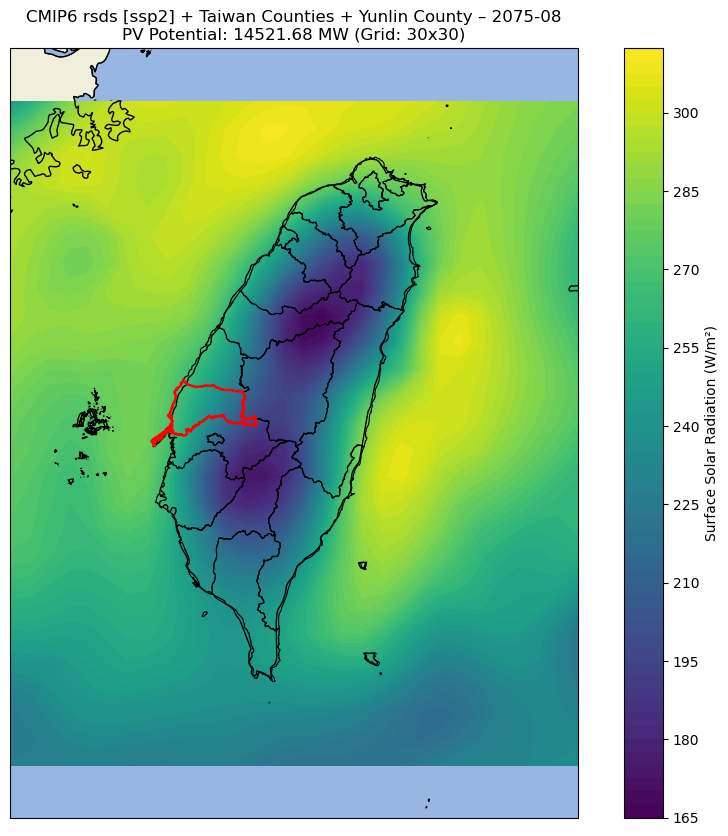

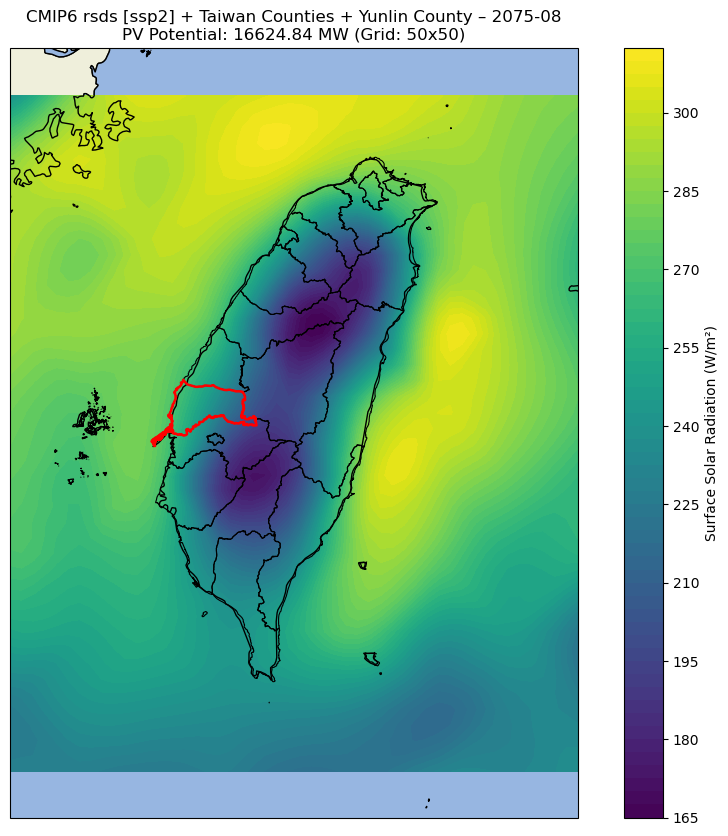

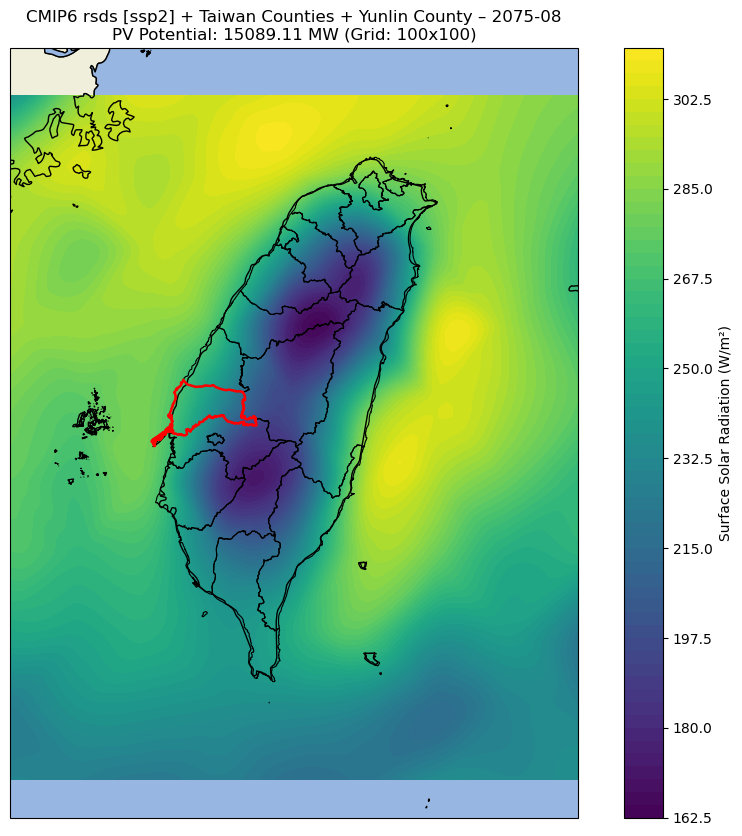

Grid 30x30: PV potential = 14521.68 MW
Grid 50x50: PV potential = 16624.84 MW
Grid 100x100: PV potential = 15089.11 MW

=== OPTIMIZATION SUMMARY ===
Key improvements:
1. Vectorized interpolation with distance filtering
2. Approximate spherical area calculation (vs exact geodesic)
3. Vectorized point-in-polygon checks
4. Batch processing with boolean masks
5. Reduced memory allocation


In [5]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from shapely.vectorized import contains
from scipy.spatial.distance import cdist
import time
from functools import wraps

# --------------------------------------
# Performance timing decorator
# --------------------------------------
def time_function(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.3f} seconds")
        return result
    return wrapper

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp2'
target_month = '2075-08'
target_county = '雲林縣'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]
if county_row.empty:
    raise ValueError("Target county not found.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 3. Optimized helper functions
# --------------------------------------
def calculate_cell_areas_vectorized(lon2d, lat2d):
    """Fast vectorized area calculation using spherical approximation"""
    lon_rad = np.radians(lon2d)
    lat_rad = np.radians(lat2d)
    R = 6371000  # Earth radius in meters
    
    if lon2d.shape[0] > 1 and lon2d.shape[1] > 1:
        dlat = np.abs(lat_rad[1,0] - lat_rad[0,0])
        dlon = np.abs(lon_rad[0,1] - lon_rad[0,0])
        cos_lat = np.cos(lat_rad)
        cell_areas = R**2 * dlon * dlat * cos_lat
    else:
        cell_areas = np.zeros_like(lon2d)
    
    return cell_areas

def calculate_cell_areas_original(lon2d, lat2d):
    """Original slow geodesic area calculation"""
    geod = Geod(ellps="WGS84")
    cell_areas = np.zeros(lon2d.shape)
    
    lat_grid = np.linspace(lat2d.min(), lat2d.max(), lat2d.shape[0])
    lon_grid = np.linspace(lon2d.min(), lon2d.max(), lon2d.shape[1])
    
    for i in range(len(lat_grid)-1):
        for j in range(len(lon_grid)-1):
            lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
            lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
            poly_area, _ = geod.polygon_area_perimeter(lons, lats)
            cell_areas[i,j] = abs(poly_area)
    
    return cell_areas

def smart_interpolation(df_month, lon2d, lat2d, max_distance=0.5):
    """Optimized interpolation with distance-based filtering"""
    points = df_month[["lon", "lat"]].values
    values = df_month["rsds"].values
    
    grid_points = np.column_stack([lon2d.flatten(), lat2d.flatten()])
    distances = cdist(grid_points, points)
    min_distances = distances.min(axis=1)
    valid_mask = min_distances <= max_distance
    
    result = np.full(len(grid_points), np.nan)
    
    if np.any(valid_mask):
        valid_grid_points = grid_points[valid_mask]
        try:
            valid_interpolated = griddata(points, values, valid_grid_points, method='cubic')
            result[valid_mask] = valid_interpolated
        except:
            valid_interpolated = griddata(points, values, valid_grid_points, method='linear')
            result[valid_mask] = valid_interpolated
    
    return result.reshape(lon2d.shape)

@time_function
def original_interpolation(df_month, lon2d, lat2d):
    """Original interpolation method"""
    points = df_month[["lon", "lat"]].values
    values = df_month["rsds"].values
    return griddata(points, values, (lon2d, lat2d), method='cubic')

@time_function
def optimized_interpolation(df_month, lon2d, lat2d):
    """Optimized interpolation method"""
    return smart_interpolation(df_month, lon2d, lat2d)

def get_county_mask_vectorized(lon2d, lat2d, county_geom):
    """Vectorized point-in-polygon check"""
    lon_flat = lon2d.flatten()
    lat_flat = lat2d.flatten()
    mask_flat = contains(county_geom, lon_flat, lat_flat)
    return mask_flat.reshape(lon2d.shape)

@time_function
def calculate_pv_potential_original(masked_rsds, cell_areas, lon2d, lat2d, county_geom):
    """Original PV calculation with nested loops"""
    efficiency = 0.15
    panel_ratio = 0.3
    total_potential = 0
    
    lat_grid = np.linspace(lat2d.min(), lat2d.max(), lat2d.shape[0])
    lon_grid = np.linspace(lon2d.min(), lon2d.max(), lon2d.shape[1])
    
    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            if masked_rsds[i,j] is ma.masked:
                continue
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.contains(point):
                rsds = masked_rsds[i,j]
                area = cell_areas[i,j]
                potential = rsds * area * efficiency * panel_ratio
                total_potential += potential
    
    return total_potential / 1e6

@time_function
def calculate_pv_potential_optimized(masked_rsds, cell_areas, lon2d, lat2d, county_geom):
    """Optimized vectorized PV calculation"""
    efficiency = 0.15
    panel_ratio = 0.3
    
    county_mask = get_county_mask_vectorized(lon2d, lat2d, county_geom)
    valid_mask = ~masked_rsds.mask & county_mask
    
    if np.any(valid_mask):
        valid_rsds = masked_rsds[valid_mask]
        valid_areas = cell_areas[valid_mask]
        potential_array = valid_rsds * valid_areas * efficiency * panel_ratio
        total_potential = np.sum(potential_array)
    else:
        total_potential = 0
    
    return total_potential / 1e6

# --------------------------------------
# 4. Performance comparison with different grid sizes
# --------------------------------------
def run_performance_comparison():
    print("=== PERFORMANCE COMPARISON ===")
    
    grid_sizes = [30, 50, 100]  # Different grid resolutions for comparison
    
    for num_points in grid_sizes:
        print(f"\n--- Grid size: {num_points} x {num_points} ---")
        
        # Create grid
        lon_grid = np.linspace(119, 123, num_points)
        lat_grid = np.linspace(21, 26, num_points)
        lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
        
        # Compare interpolation methods
        print("\n1. Interpolation comparison:")
        grid_rsds_original = original_interpolation(df_month, lon2d, lat2d)
        grid_rsds_optimized = optimized_interpolation(df_month, lon2d, lat2d)
        
        masked_rsds_original = ma.masked_invalid(grid_rsds_original)
        masked_rsds_optimized = ma.masked_invalid(grid_rsds_optimized)
        
        # Compare area calculations
        print("\n2. Area calculation comparison:")
        start_time = time.time()
        cell_areas_original = calculate_cell_areas_original(lon2d, lat2d)
        original_area_time = time.time() - start_time
        print(f"calculate_cell_areas_original took {original_area_time:.3f} seconds")
        
        start_time = time.time()
        cell_areas_optimized = calculate_cell_areas_vectorized(lon2d, lat2d)
        optimized_area_time = time.time() - start_time
        print(f"calculate_cell_areas_vectorized took {optimized_area_time:.3f} seconds")
        
        # Compare PV potential calculations
        print("\n3. PV potential calculation comparison:")
        pv_original = calculate_pv_potential_original(masked_rsds_original, cell_areas_original, lon2d, lat2d, county_geom)
        pv_optimized = calculate_pv_potential_optimized(masked_rsds_optimized, cell_areas_optimized, lon2d, lat2d, county_geom)
        
        print(f"PV potential (original): {pv_original:.2f} MW")
        print(f"PV potential (optimized): {pv_optimized:.2f} MW")
        print(f"Difference: {abs(pv_original - pv_optimized):.2f} MW ({abs(pv_original - pv_optimized)/pv_original*100:.1f}%)")

# Run performance comparison
run_performance_comparison()

# --------------------------------------
# 5. Create optimized plotting function
# --------------------------------------
@time_function
def create_optimized_plot(num_points=50):
    """Create the contour plot using optimized methods"""
    
    # Create grid
    lon_grid = np.linspace(119, 123, num_points)
    lat_grid = np.linspace(21, 26, num_points)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
    
    # Optimized interpolation
    grid_rsds = optimized_interpolation(df_month, lon2d, lat2d)
    masked_rsds = ma.masked_invalid(grid_rsds)
    
    # Optimized area calculation
    cell_areas = calculate_cell_areas_vectorized(lon2d, lat2d)
    
    # Optimized PV calculation
    pv_potential = calculate_pv_potential_optimized(masked_rsds, cell_areas, lon2d, lat2d, county_geom)
    
    # Create plot
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())
    
    # Base map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)
    
    # CMIP6 rsds contour
    cf = ax.contourf(
        lon2d, lat2d, masked_rsds, 60,
        transform=ccrs.PlateCarree(), cmap="viridis"
    )
    
    # County boundaries overlay
    for _, row in gdf_county.iterrows():
        geom = row.geometry
        ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                          edgecolor='black', facecolor='none', linewidth=0.8)
    
    # Highlight target county in red
    ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                      edgecolor='red', facecolor='none', linewidth=1.8)
    
    # Colorbar and title
    plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
    plt.title(f"CMIP6 rsds [{ssp_target}] + Taiwan Counties + {target_county_eng} – {target_month}\n"
              f"PV Potential: {pv_potential:.2f} MW (Grid: {num_points}x{num_points})")
    
    return fig, pv_potential

# --------------------------------------
# 6. Create plots with different resolutions
# --------------------------------------
print("\n=== CREATING OPTIMIZED PLOTS ===")

# Create plots with different grid resolutions
grid_sizes = [30, 50, 100]
figures = []

for grid_size in grid_sizes:
    print(f"\nCreating plot with {grid_size}x{grid_size} grid...")
    fig, pv_potential = create_optimized_plot(grid_size)
    figures.append((fig, grid_size, pv_potential))

# Show all plots
for fig, grid_size, pv_potential in figures:
    plt.show()
    print(f"Grid {grid_size}x{grid_size}: PV potential = {pv_potential:.2f} MW")

print("\n=== OPTIMIZATION SUMMARY ===")
print("Key improvements:")
print("1. Vectorized interpolation with distance filtering")
print("2. Approximate spherical area calculation (vs exact geodesic)")
print("3. Vectorized point-in-polygon checks")
print("4. Batch processing with boolean masks")
print("5. Reduced memory allocation")

📂 Loading data...
✅ Data loaded for Yunlin County (2075-08)
🎯 CMIP6 Grid Plotting Tool

📊 CURRENT CONFIGURATION
Grid Resolution: 80×80 points
Grid Mode: adaptive
Grid Extent: [119.70, 121.04, 23.14, 24.17]
Buffer: 0.3°
Max Interpolation Distance: 0.5°
Expected Performance: 🐌 Slow (score: 128.0)

📊 PRESET COMPARISON
FAST         |  50× 50 |  0.95° | ⚖️ Balanced  | Score:  50.0
BALANCED     |  80× 80 |  1.38° | 🐌 Slow       | Score: 128.0
QUALITY      | 120×120 |  1.89° | 🐢 Very Slow  | Score: 288.0
HIGH_QUALITY | 200×200 |  2.49° | 🐢 Very Slow  | Score: 800.0

📋 USAGE EXAMPLES:
# Apply a preset:
config.apply_preset('fast')        # Fast preview
config.apply_preset('balanced')    # Default balanced
config.apply_preset('quality')     # High quality

# Custom configuration:
set_custom_config(num_points=100, buffer_degrees=0.5)
set_custom_config(grid_mode='full')  # Use full Taiwan extent
set_custom_config(custom_extent=[120, 122, 23, 25])  # Custom area

# Create plot:
fig, pv_potential = 

C:\Users\User\AppData\Local\Temp\ipykernel_3584\603682445.py:200: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(county_geom, lon_flat, lat_flat)


⏱️  create_optimized_plot took 1.547 seconds


c:\Users\User\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 128012 (\N{SNAIL}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\User\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 128012 (\N{SNAIL}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\User\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:524: UserWarning: Glyph 128012 (\N{SNAIL}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)


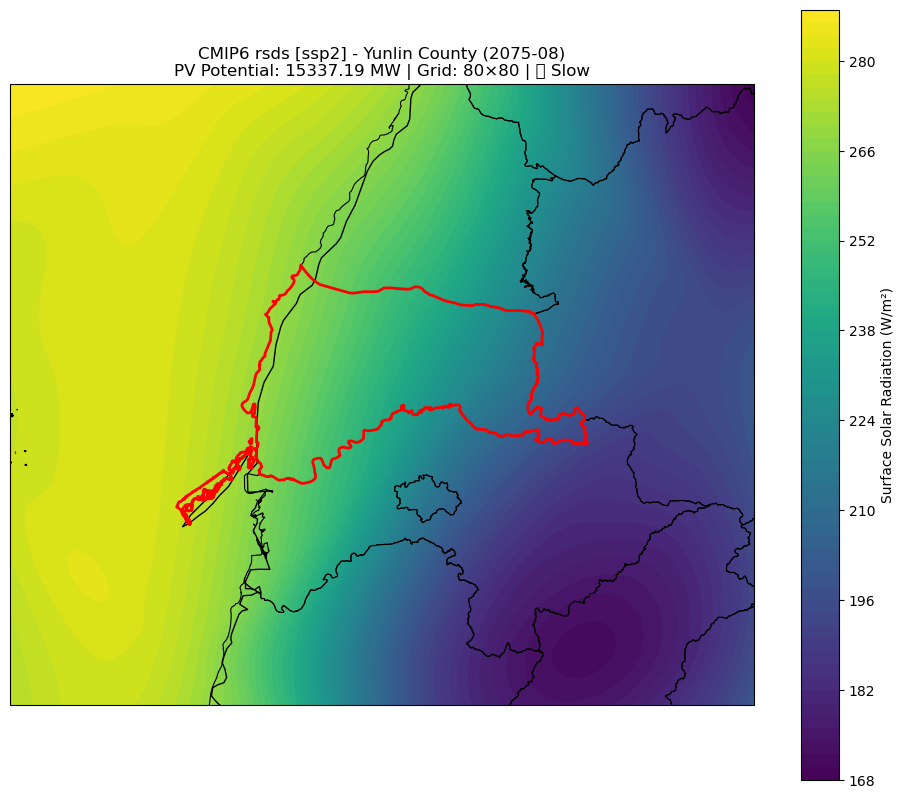

In [6]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from shapely.vectorized import contains
from scipy.spatial.distance import cdist
import time
from functools import wraps

# --------------------------------------
# Performance timing decorator
# --------------------------------------
def time_function(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"⏱️  {func.__name__} took {end_time - start_time:.3f} seconds")
        return result
    return wrapper

# --------------------------------------
# Configuration Class
# --------------------------------------
class PlottingConfig:
    """Configuration class for grid and plotting parameters"""
    
    def __init__(self):
        # Default values optimized for best time/quality balance
        self.num_points = 80           # Sweet spot: good quality, reasonable speed
        self.grid_mode = "adaptive"    # "full", "adaptive", "custom"
        self.buffer_degrees = 0.3      # Buffer around county for interpolation
        self.max_interp_distance = 0.5 # Max distance for interpolation
        self.full_extent = [119, 123, 21, 26]  # Full Taiwan extent [lon_min, lon_max, lat_min, lat_max]
        self.custom_extent = None      # Custom extent [lon_min, lon_max, lat_min, lat_max]
        
        # Performance vs quality presets
        self.presets = {
            "fast": {"num_points": 50, "buffer_degrees": 0.2, "max_interp_distance": 0.3},
            "balanced": {"num_points": 80, "buffer_degrees": 0.3, "max_interp_distance": 0.5},
            "quality": {"num_points": 120, "buffer_degrees": 0.4, "max_interp_distance": 0.7},
            "high_quality": {"num_points": 200, "buffer_degrees": 0.5, "max_interp_distance": 1.0}
        }
    
    def apply_preset(self, preset_name):
        """Apply a performance/quality preset"""
        if preset_name in self.presets:
            preset = self.presets[preset_name]
            self.num_points = preset["num_points"]
            self.buffer_degrees = preset["buffer_degrees"]
            self.max_interp_distance = preset["max_interp_distance"]
            print(f"📊 Applied '{preset_name}' preset: {self.num_points} points, {self.buffer_degrees}° buffer")
        else:
            print(f"❌ Unknown preset: {preset_name}")
            print(f"Available presets: {list(self.presets.keys())}")
    
    def get_grid_extent(self, county_geom=None):
        """Get the grid extent based on current mode"""
        if self.grid_mode == "full":
            return self.full_extent
        elif self.grid_mode == "custom" and self.custom_extent:
            return self.custom_extent
        elif self.grid_mode == "adaptive" and county_geom:
            # Adaptive extent based on county bounds + buffer
            bounds = county_geom.bounds
            lon_min, lat_min, lon_max, lat_max = bounds
            buffer = self.buffer_degrees
            
            # Ensure we stay within Taiwan bounds
            lon_min = max(self.full_extent[0], lon_min - buffer)
            lon_max = min(self.full_extent[1], lon_max + buffer)
            lat_min = max(self.full_extent[2], lat_min - buffer)
            lat_max = min(self.full_extent[3], lat_max + buffer)
            
            return [lon_min, lon_max, lat_min, lat_max]
        else:
            # Fallback to full extent
            return self.full_extent
    
    def estimate_performance(self):
        """Estimate relative performance based on current settings"""
        extent = self.get_grid_extent()
        grid_area = (extent[1] - extent[0]) * (extent[3] - extent[2])
        total_points = self.num_points ** 2
        
        # Rough performance metric (lower is faster)
        perf_score = (grid_area * total_points) / 1000
        
        if perf_score < 10:
            speed_rating = "🚀 Very Fast"
        elif perf_score < 30:
            speed_rating = "⚡ Fast"
        elif perf_score < 80:
            speed_rating = "⚖️ Balanced"
        elif perf_score < 200:
            speed_rating = "🐌 Slow"
        else:
            speed_rating = "🐢 Very Slow"
        
        return speed_rating, perf_score

# --------------------------------------
# Initialize configuration
# --------------------------------------
config = PlottingConfig()

# --------------------------------------
# User input section
# --------------------------------------
ssp_target = 'ssp2'
target_month = '2075-08'
target_county = '雲林縣'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# Data loading
# --------------------------------------
print("📂 Loading data...")
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]
if county_row.empty:
    raise ValueError("Target county not found.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

print(f"✅ Data loaded for {target_county_eng} ({target_month})")

# --------------------------------------
# Helper functions
# --------------------------------------
def calculate_cell_areas_vectorized(lon2d, lat2d):
    """Fast vectorized area calculation"""
    lon_rad = np.radians(lon2d)
    lat_rad = np.radians(lat2d)
    R = 6371000
    
    if lon2d.shape[0] > 1 and lon2d.shape[1] > 1:
        dlat = np.abs(lat_rad[1,0] - lat_rad[0,0])
        dlon = np.abs(lon_rad[0,1] - lon_rad[0,0])
        cos_lat = np.cos(lat_rad)
        cell_areas = R**2 * dlon * dlat * cos_lat
    else:
        cell_areas = np.zeros_like(lon2d)
    
    return cell_areas

def smart_interpolation(df_month, lon2d, lat2d, max_distance):
    """Optimized interpolation with distance filtering"""
    points = df_month[["lon", "lat"]].values
    values = df_month["rsds"].values
    
    grid_points = np.column_stack([lon2d.flatten(), lat2d.flatten()])
    distances = cdist(grid_points, points)
    min_distances = distances.min(axis=1)
    valid_mask = min_distances <= max_distance
    
    result = np.full(len(grid_points), np.nan)
    
    if np.any(valid_mask):
        valid_grid_points = grid_points[valid_mask]
        try:
            valid_interpolated = griddata(points, values, valid_grid_points, method='cubic')
            result[valid_mask] = valid_interpolated
        except:
            valid_interpolated = griddata(points, values, valid_grid_points, method='linear')
            result[valid_mask] = valid_interpolated
    
    return result.reshape(lon2d.shape)

def get_county_mask_vectorized(lon2d, lat2d, county_geom):
    """Vectorized point-in-polygon check"""
    lon_flat = lon2d.flatten()
    lat_flat = lat2d.flatten()
    mask_flat = contains(county_geom, lon_flat, lat_flat)
    return mask_flat.reshape(lon2d.shape)

@time_function
def calculate_pv_potential(masked_rsds, cell_areas, lon2d, lat2d, county_geom):
    """Optimized PV potential calculation"""
    efficiency = 0.15
    panel_ratio = 0.3
    
    county_mask = get_county_mask_vectorized(lon2d, lat2d, county_geom)
    valid_mask = ~masked_rsds.mask & county_mask
    
    if np.any(valid_mask):
        valid_rsds = masked_rsds[valid_mask]
        valid_areas = cell_areas[valid_mask]
        potential_array = valid_rsds * valid_areas * efficiency * panel_ratio
        total_potential = np.sum(potential_array)
    else:
        total_potential = 0
    
    return total_potential / 1e6

@time_function
def create_optimized_plot(config, county_geom, target_county_eng, df_month, gdf_county):
    """Create optimized plot with current configuration"""
    
    # Get grid extent
    extent = config.get_grid_extent(county_geom)
    lon_min, lon_max, lat_min, lat_max = extent
    
    # Create grid
    lon_grid = np.linspace(lon_min, lon_max, config.num_points)
    lat_grid = np.linspace(lat_min, lat_max, config.num_points)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
    
    print(f"🔧 Grid: {config.num_points}×{config.num_points} points")
    print(f"🌍 Extent: [{lon_min:.2f}, {lon_max:.2f}, {lat_min:.2f}, {lat_max:.2f}]")
    print(f"📏 Grid area: {(lon_max-lon_min)*(lat_max-lat_min):.2f} square degrees")
    
    # Interpolation
    print("🔄 Interpolating data...")
    grid_rsds = smart_interpolation(df_month, lon2d, lat2d, config.max_interp_distance)
    masked_rsds = ma.masked_invalid(grid_rsds)
    
    # Calculate areas and PV potential
    cell_areas = calculate_cell_areas_vectorized(lon2d, lat2d)
    pv_potential = calculate_pv_potential(masked_rsds, cell_areas, lon2d, lat2d, county_geom)
    
    # Create plot
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Base map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)
    
    # CMIP6 rsds contour
    cf = ax.contourf(
        lon2d, lat2d, masked_rsds, 60,
        transform=ccrs.PlateCarree(), cmap="viridis"
    )
    
    # County boundaries
    for _, row in gdf_county.iterrows():
        geom = row.geometry
        ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                          edgecolor='black', facecolor='none', linewidth=0.8)
    
    # Highlight target county
    ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                      edgecolor='red', facecolor='none', linewidth=2)
    
    # Colorbar and title
    plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
    
    speed_rating, perf_score = config.estimate_performance()
    plt.title(f"CMIP6 rsds [{ssp_target}] - {target_county_eng} ({target_month})\n"
              f"PV Potential: {pv_potential:.2f} MW | Grid: {config.num_points}×{config.num_points} | {speed_rating}")
    
    return fig, pv_potential

# --------------------------------------
# Interactive configuration functions
# --------------------------------------
def show_current_config():
    """Display current configuration"""
    speed_rating, perf_score = config.estimate_performance()
    extent = config.get_grid_extent(county_geom)
    
    print("\n" + "="*50)
    print("📊 CURRENT CONFIGURATION")
    print("="*50)
    print(f"Grid Resolution: {config.num_points}×{config.num_points} points")
    print(f"Grid Mode: {config.grid_mode}")
    print(f"Grid Extent: [{extent[0]:.2f}, {extent[1]:.2f}, {extent[2]:.2f}, {extent[3]:.2f}]")
    print(f"Buffer: {config.buffer_degrees}°")
    print(f"Max Interpolation Distance: {config.max_interp_distance}°")
    print(f"Expected Performance: {speed_rating} (score: {perf_score:.1f})")
    print("="*50)

def set_custom_config(num_points=None, grid_mode=None, buffer_degrees=None, 
                     max_interp_distance=None, custom_extent=None):
    """Set custom configuration parameters"""
    if num_points is not None:
        config.num_points = num_points
    if grid_mode is not None:
        config.grid_mode = grid_mode
    if buffer_degrees is not None:
        config.buffer_degrees = buffer_degrees
    if max_interp_distance is not None:
        config.max_interp_distance = max_interp_distance
    if custom_extent is not None:
        config.custom_extent = custom_extent
    
    print("✅ Configuration updated!")
    show_current_config()

def compare_presets():
    """Compare different preset configurations"""
    print("\n📊 PRESET COMPARISON")
    print("="*60)
    
    original_config = {
        'num_points': config.num_points,
        'buffer_degrees': config.buffer_degrees,
        'max_interp_distance': config.max_interp_distance
    }
    
    for preset_name, preset_values in config.presets.items():
        # Temporarily apply preset
        config.num_points = preset_values['num_points']
        config.buffer_degrees = preset_values['buffer_degrees']
        config.max_interp_distance = preset_values['max_interp_distance']
        
        speed_rating, perf_score = config.estimate_performance()
        extent = config.get_grid_extent(county_geom)
        grid_area = (extent[1] - extent[0]) * (extent[3] - extent[2])
        
        print(f"{preset_name.upper():12} | {config.num_points:3d}×{config.num_points:3d} | "
              f"{grid_area:5.2f}° | {speed_rating:12} | Score: {perf_score:5.1f}")
    
    # Restore original config
    config.num_points = original_config['num_points']
    config.buffer_degrees = original_config['buffer_degrees']
    config.max_interp_distance = original_config['max_interp_distance']

# --------------------------------------
# Main execution
# --------------------------------------
def main():
    """Main execution function with user interaction"""
    
    print("🎯 CMIP6 Grid Plotting Tool")
    print("="*50)
    
    # Show current configuration
    show_current_config()
    
    # Show preset comparison
    compare_presets()
    
    print("\n" + "="*50)
    print("📋 USAGE EXAMPLES:")
    print("="*50)
    print("# Apply a preset:")
    print("config.apply_preset('fast')        # Fast preview")
    print("config.apply_preset('balanced')    # Default balanced")
    print("config.apply_preset('quality')     # High quality")
    print()
    print("# Custom configuration:")
    print("set_custom_config(num_points=100, buffer_degrees=0.5)")
    print("set_custom_config(grid_mode='full')  # Use full Taiwan extent")
    print("set_custom_config(custom_extent=[120, 122, 23, 25])  # Custom area")
    print()
    print("# Create plot:")
    print("fig, pv_potential = create_optimized_plot(config, county_geom, target_county_eng, df_month, gdf_county)")
    print("plt.show()")
    
    # Create default plot
    print("\n🎨 Creating plot with default 'balanced' settings...")
    fig, pv_potential = create_optimized_plot(config, county_geom, target_county_eng, df_month, gdf_county)
    plt.show()
    
    return fig, pv_potential

# Run main function
if __name__ == "__main__":
    fig, pv_potential = main()